In [1]:
import numpy as np
from PIL import Image
import csv
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt 
import seaborn as sn
from sklearn.metrics import roc_auc_score
%matplotlib inline

**Ground Truth Predictions**

In [2]:
valid = pd.read_json("dev_seen.jsonl", lines=True)


In [3]:
valid.head()

id            img  label  \
0   8291  img/08291.png      1   
1  46971  img/46971.png      1   
2   3745  img/03745.png      1   
3  83745  img/83745.png      1   
4  80243  img/80243.png      1   

                                                text  
0              white people is this a shooting range  
1                              bravery at its finest  
2  your order comes to $37.50 and your white priv...  
3  it is time.. to send these parasites back to t...  
4                             mississippi wind chime

In [4]:
# Ground truth labels
actual = {valid['id'][i]:valid['label'][i] for i in range(500)}

In [5]:
valid.set_index("id", inplace=True)

**Helper Functions**

In [6]:
'''
Returns True Positives, False Positives, True Negatives, False Negatives, AUROC_score
'''
def Statistics(actual, pred_labels, pred_prob, sorted_dict):
    
    #Correctly Predicted
    True_positives = defaultdict(int)
    True_negatives = defaultdict(int)


    #Benign Meme but predicted hateful
    False_positives = defaultdict(int)

    # Hateful Meme, but predicted Benign
    False_negatives = defaultdict(int)



    for ids in list(actual.keys()):

        if actual[ids] != pred_labels[ids]:

            if pred_prob[ids]>=0.5:
                False_positives[ids] = pred_prob[ids]

            else:
                 False_negatives[ids] = pred_prob[ids]   


        else:
            if pred_prob[ids]>=0.5:
                True_positives[ids] = pred_prob[ids]

            else:
                 True_negatives[ids] = pred_prob[ids]   
            
        
    return sorted_dict(True_positives), sorted_dict(True_negatives), sorted_dict(False_positives),  sorted_dict(False_negatives)
     

    

'''
Get count of True Positives, False Positives, True Negatives, False Negatives
'''
def count(True_positives, True_negatives, False_positives,  False_negatives):
    
    tp = len(True_positives)
    tn = len(True_negatives)
    fp = len(False_positives)
    fn = len(False_negatives)
    total = tp+tn+fp+fn
    
    return tp,tn,fp,fn,total




'''
Plots Confusion Matrix
'''
def plot_confusion_matrix(tn, fp, fn, tp, AUROC_score,total):
    
    
    matrix = np.array(([tn, fp],[fn,tp]))
    percent = (matrix/matrix.sum())*100
    
    accuracy = ((tp+tn)/total)*100
    Precision = (tp/(tp+fp))*100
    Recall = (tp/(tp+fn))*100
    F1_score =  2 * (Precision * Recall) / (Precision + Recall)
    
    
    df_cm = pd.DataFrame(matrix, ['Benign','Hateful'], ['Benign','Hateful'])
    text = np.asarray([['True Negatives', 'False Positives'], ['False Negatives', 'True Positives']])
    label = (np.asarray(["{0}\n\n{1}\n\n{2: .2f}%".format(text,matrix,percent) for text, matrix, percent in zip(text.flatten(), matrix.flatten(), percent.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(10,10))
    sn.set(font_scale=2)
    sn.heatmap(df_cm, annot=label, annot_kws={"size": 20}, cbar_kws={'label':"Memes"}, fmt ='', cmap ='Blues')
    
    plt.title('Confusion Matrix', fontsize=20)
    plt.text(0.1, 2.5, 'Precision: '+str(round(Precision,2)) + '        Recall: '+str(round(Recall,2))+'     F1 Score: '+str(round(F1_score,2))+
            '\n\nAccuracy: '+ str(round(accuracy,2))+'          AUROC:'+ str(round(AUROC_score,2)), fontsize=20)
    plt.xlabel('')
    plt.ylabel()
    plt.show()

    
    
    
'''
Get AUROC score using sklearn.metrics.roc_auc_score
'''
def get_AUROC(actual, pred_labels):
    
    ytrue=[]
    ypred=[]
    for ids in list(actual.keys()):
        ytrue.append(actual[ids])
        ypred.append(pred_labels[ids])

    AUROC_score = roc_auc_score(ytrue, ypred)
    
    return AUROC_score




'''
Return a Dictionary by it's values sorted in descending order
'''
def sorted_dict(unsorted_dictionary):
    sorted_keys = sorted(unsorted_dictionary, key =unsorted_dictionary.__getitem__, reverse=True)

    sorted_values = sorted(unsorted_dictionary.values(),reverse=True)

    sorted_dictionary = {}
    for i in range(len(sorted_keys)):
        sorted_dictionary[sorted_keys[i]] = sorted_values[i]
        
    return sorted_dictionary



'''
Display a Image
'''
def open_image(path, actual, pred_labels, pred_prob):
    label_dict = {0:'Benign', 1:'Hateful'}

    ground_truth = label_dict[actual[image_id]]
    predicted_label = label_dict[pred_labels[image_id]]
    confidence = pred_prob[image_id]
    
    image = Image.open('data/'+path)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.rcParams["axes.grid"] = False
    plt.text(0,image.size[1]+25, 'Annotated label: '+ ground_truth+ '       Predicted label: '+ predicted_label+ '       Probability: '+ str(round(confidence,4)), fontsize=15)
    plt.imshow(image)
    

**Analysis of Visual BERT COCO on Validation set**

**Predicted labels**

In [174]:
predicted = pd.read_csv('hateful_memes_run_val_2020-11-13T02_20_30.csv')

In [175]:
predicted.head()

id     proba  label
0  98701  0.000820      0
1  98543  0.957242      1
2   2157  0.012254      0
3  10785  0.001090      0
4   6491  0.999141      1

In [176]:
# Predicted Labels
pred_labels = {predicted['id'][i]:predicted['label'][i] for i in range(500)}

In [177]:
# Predicted Probabilities
pred_prob = {predicted['id'][i]:predicted['proba'][i] for i in range(500)}

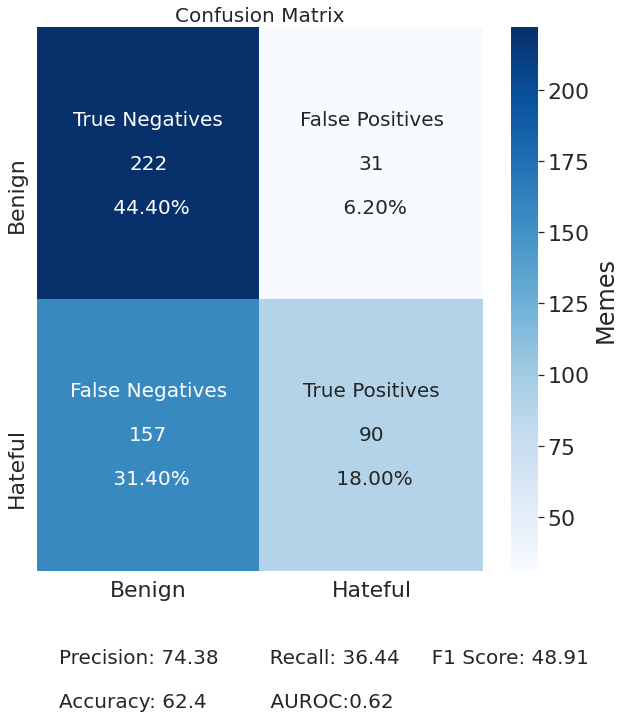

In [178]:
True_positives, True_negatives, False_positives,  False_negatives =  Statistics(actual, pred_labels, pred_prob, sorted_dict)

tp,tn,fp,fn,total = count(True_positives, True_negatives, False_positives,  False_negatives)

AUROC_score = get_AUROC(actual, pred_labels)

plot_confusion_matrix(tn, fp, fn, tp, AUROC_score, total)

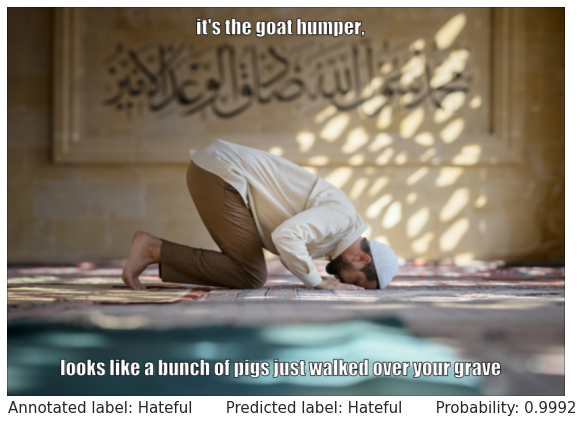

In [179]:
# True Positive with Highest Confidence (Hateful Meme predicted as Hateful)

path = valid.loc[list(True_positives.keys())[0]]['img']
image_id = list(True_positives.keys())[0]
open_image(path, actual, pred_labels, pred_prob)

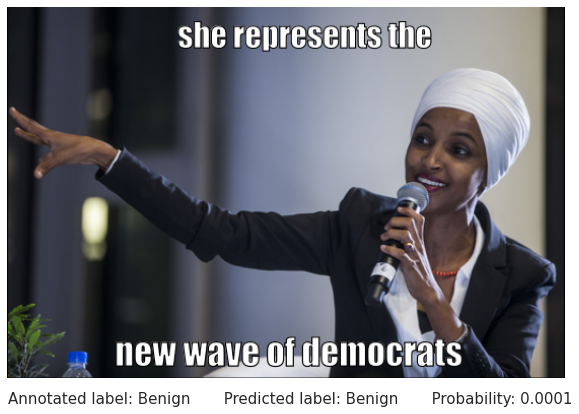

In [187]:
# True Negative with Highest Confidence (Benign meme predicted as Benign)
path = valid.loc[list(True_negatives.keys())[-3]]['img']
image_id = list(True_negatives.keys())[-3]

open_image(path, actual, pred_labels, pred_prob)

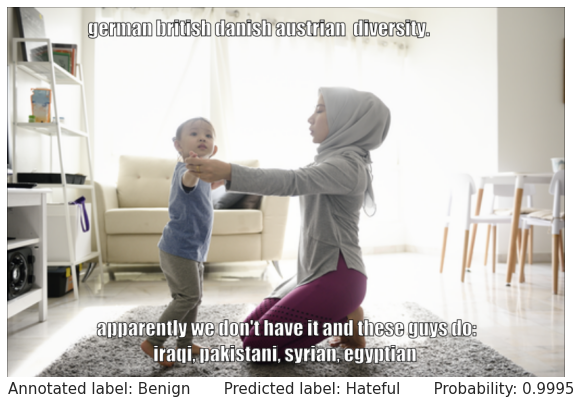

In [181]:
# False Positive with Highest Confidence (Benign meme prediced as Hateful)
path = valid.loc[list(False_positives.keys())[0]]['img']
image_id = list(False_positives.keys())[0]
open_image(path, actual, pred_labels, pred_prob)

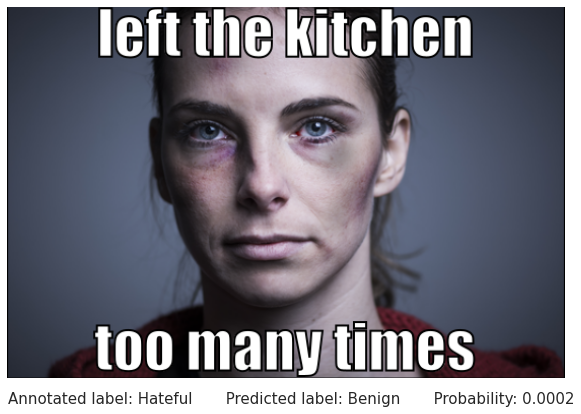

In [185]:
# False Negative with Highest Confidence (Hateful Meme predicted as Benign)
path = valid.loc[list(False_negatives.keys())[-1]]['img']
image_id = list(False_negatives.keys())[-1]
open_image(path, actual, pred_labels, pred_prob)

**Analysis of VilBERT CC on Validation set**

In [7]:
predicted = pd.read_csv('hateful_memes_run_val_2020-11-14T00_33_22.csv')

In [8]:
predicted.head()

id         proba  label
0   1268  9.078556e-08      0
1  76295  3.045944e-05      0
2   3524  9.725998e-07      0
3  61872  6.608395e-06      0
4  19243  6.383877e-07      0

In [9]:
# Predicted Labels
pred_labels = {predicted['id'][i]:predicted['label'][i] for i in range(500)}

In [10]:
# Predicted Probabilities
pred_prob = {predicted['id'][i]:predicted['proba'][i] for i in range(500)}

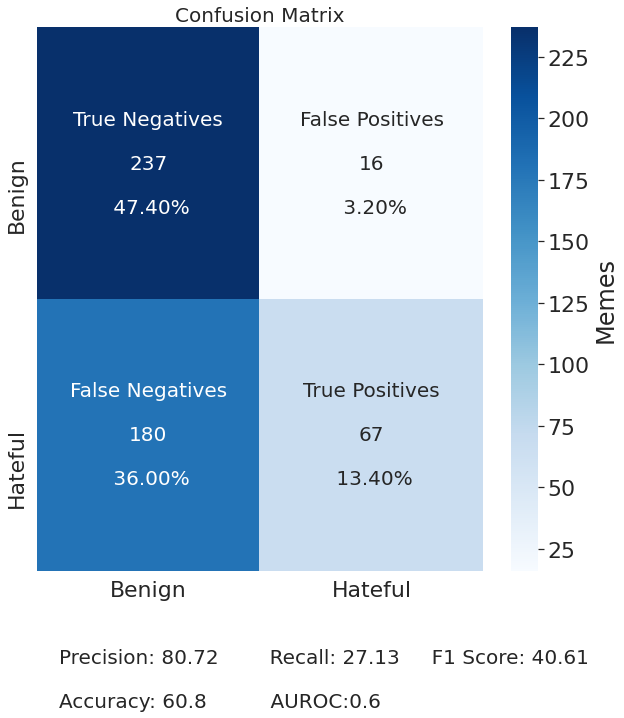

In [11]:
True_positives, True_negatives, False_positives,  False_negatives =  Statistics(actual, pred_labels, pred_prob, sorted_dict)

tp,tn,fp,fn,total = count(True_positives, True_negatives, False_positives,  False_negatives)

AUROC_score = get_AUROC(actual, pred_labels)

plot_confusion_matrix(tn, fp, fn, tp, AUROC_score, total)

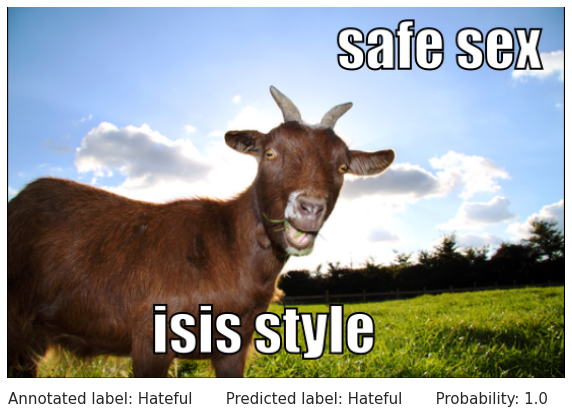

In [12]:
# True Positive with Highest Confidence (Hateful Meme predicted as Hateful)

path = valid.loc[list(True_positives.keys())[0]]['img']
# open_image(path)
image_id = list(True_positives.keys())[0]
open_image(path, actual, pred_labels, pred_prob)

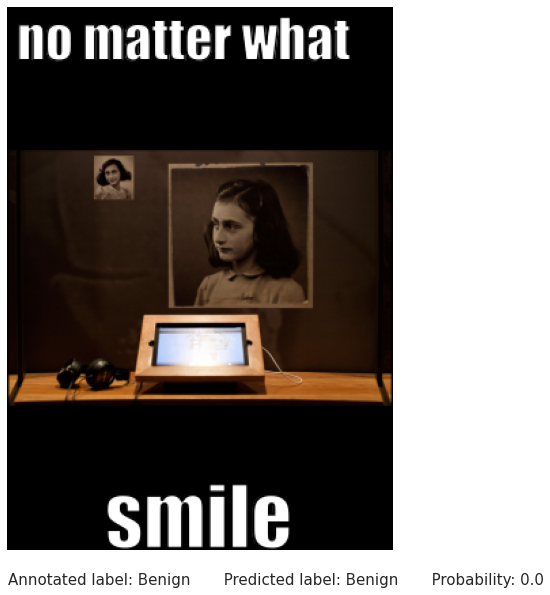

In [194]:
# True Negative with Highest Confidence (Benign meme predicted as Benign)
path = valid.loc[list(True_negatives.keys())[-1]]['img']
# open_image(path)
image_id = list(True_negatives.keys())[-1]
open_image(path, actual, pred_labels, pred_prob)

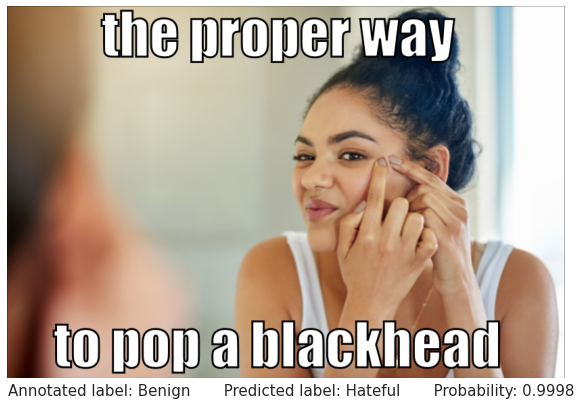

In [195]:
# False Positive with Highest Confidence (Benign meme prediced as Hateful)
path = valid.loc[list(False_positives.keys())[4]]['img']
image_id = list(False_positives.keys())[4]
open_image(path, actual, pred_labels, pred_prob)

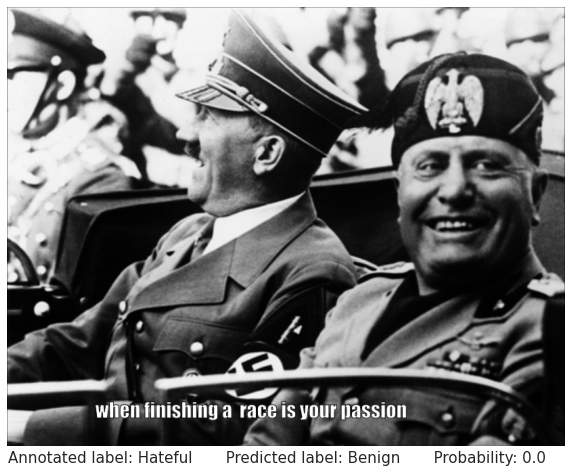

In [34]:
# False Negative with Highest Confidence (Hateful Meme predicted as Benign)
path = valid.loc[list(False_negatives.keys())[-7]]['img']
image_id = list(False_negatives.keys())[-7]
open_image(path, actual, pred_labels, pred_prob)

**Analysis of VilBERT on Validation set**

In [38]:
predicted = pd.read_csv('hateful_memes_run_val_2020-11-13T21_04_12.csv')

In [39]:
predicted.head()

id     proba  label
0  90243  0.245307      0
1  54893  0.381072      0
2  71680  0.758425      1
3  28190  0.465289      0
4  47819  0.482293      0

In [40]:
# Predicted Labels
pred_labels = {predicted['id'][i]:predicted['label'][i] for i in range(500)}

In [41]:
# Predicted Probabilities
pred_prob = {predicted['id'][i]:predicted['proba'][i] for i in range(500)}

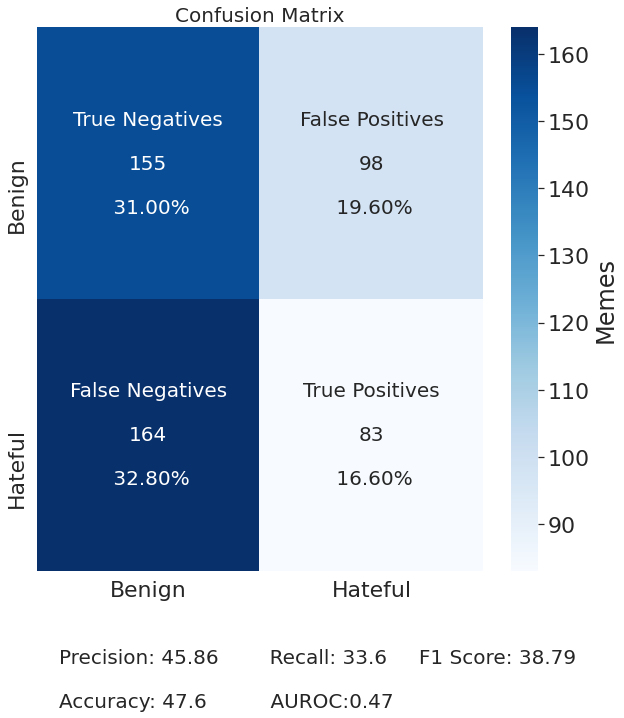

In [42]:
True_positives, True_negatives, False_positives,  False_negatives =  Statistics(actual, pred_labels, pred_prob, sorted_dict)

tp,tn,fp,fn,total = count(True_positives, True_negatives, False_positives,  False_negatives)

AUROC_score = get_AUROC(actual, pred_labels)

plot_confusion_matrix(tn, fp, fn, tp, AUROC_score, total)

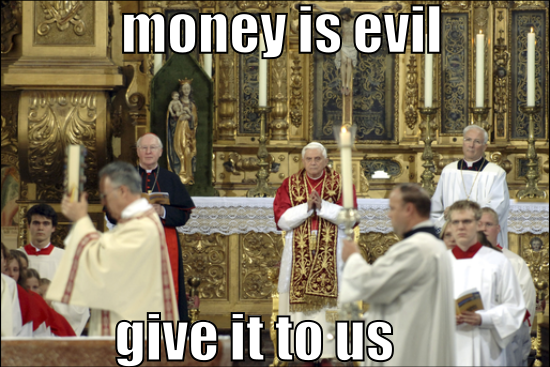

In [43]:
# True Positive with Highest Confidence (Hateful Meme predicted as Hateful)

path = valid.loc[list(True_positives.keys())[0]]['img']
open_image(path)

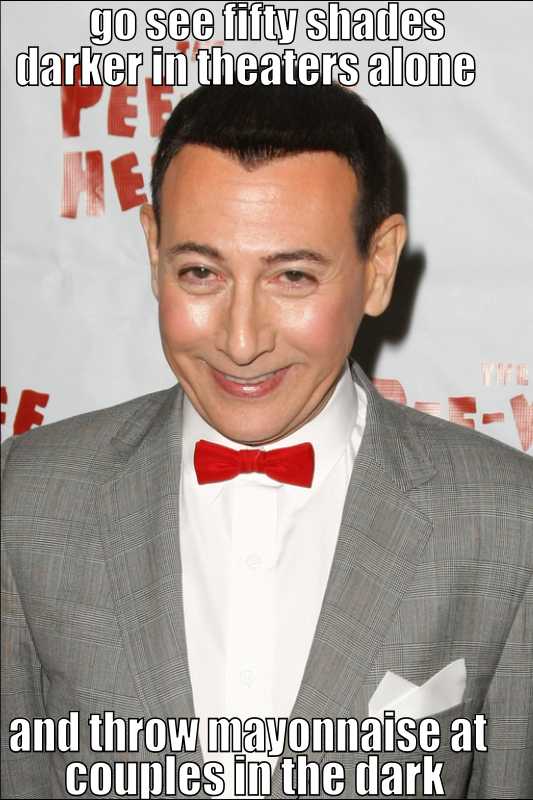

In [45]:
# True Negative with Highest Confidence (Benign meme predicted as Benign)
path = valid.loc[list(True_negatives.keys())[-2]]['img']
open_image(path)

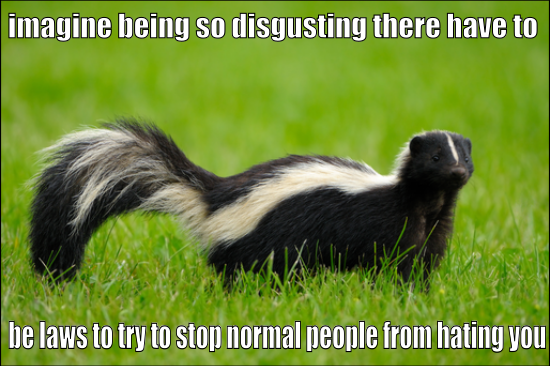

In [46]:
# False Positive with Highest Confidence (Benign meme prediced as Hateful)
path = valid.loc[list(False_positives.keys())[0]]['img']
open_image(path)

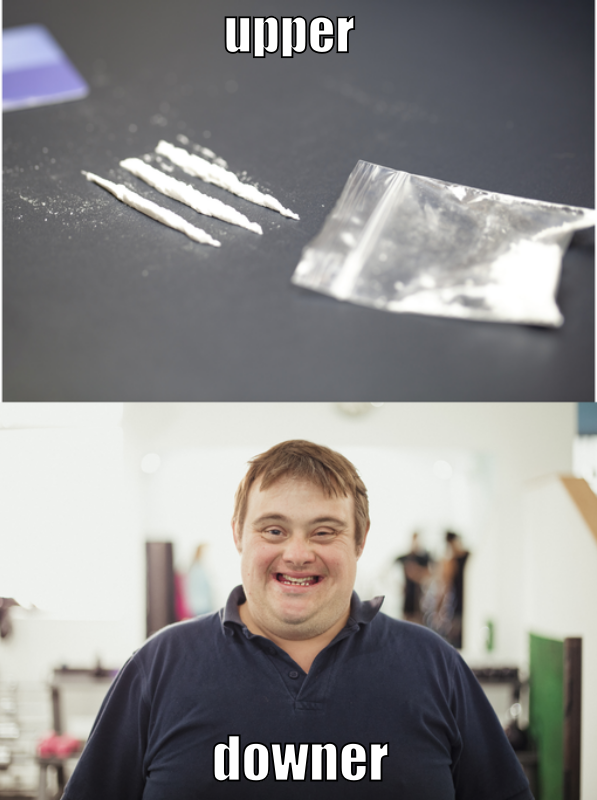

In [47]:
# False Negative with Highest Confidence (Hateful Meme predicted as Benign)
path = valid.loc[list(False_negatives.keys())[-1]]['img']
open_image(path)